In [8]:
import IPython.display as ipd
import torch
import matplotlib.pyplot as plt
import scipy.io
import numpy as np
import torch.nn.functional as F
import librosa.output
from matplotlib import cm
import matplotlib

In [9]:
matplotlib.style.use('ggplot')

In [10]:
from data import SpatialAudioDatasetWaveform
from network import center_trim, left_trim, Demucs

In [11]:
test_dir = '/projects/grail/audiovisual/datasets/DinTaiFung/6mics_fixedvoice_bgvol0.15/test'
data_test = SpatialAudioDatasetWaveform(test_dir, n_sources=1, n_backgrounds=1)
device = torch.device('cuda:0')

In [12]:
!ls /projects/grail/audiovisual/datasets/DinTaiFung/

1_voice_1_bg_hard	      mics_8_radius_3_voice_1_bg_1_all
6mics_fixedvoice_bgvol0.15    mics_8_radius_3_voice_1_bg_1_all_noatten
6mics_fixedvoice_bgvol0.3     simple_1_voice_1_bg
mics_8_radius_3		      simple_1_voice_1_bg_hard
mics_8_radius_3_voice_1_bg_1  simple_1_voice_1_bg_harder


In [13]:
kwargs = {
    'num_workers': 4,
    'pin_memory': True
}

In [19]:
test_loader = torch.utils.data.DataLoader(data_test,
                                          batch_size=40,
                                          **kwargs)

In [20]:
%ls checkpoints/shifted_input*

checkpoints/shifted_input_0.pt  checkpoints/shifted_input_lr1e-3_0.pt
checkpoints/shifted_input_1.pt  checkpoints/shifted_input_lr1e-3_1.pt
checkpoints/shifted_input_2.pt


In [21]:
model = Demucs(sources=2, n_audio_channels=6)

In [22]:
# model.load_state_dict(torch.load('checkpoints/mics8_radius3_demucs_nospatial_47.pt'))
# model.load_state_dict(torch.load('checkpoints/mics8_radius3_demucs_nospatial_10.pt').module.state_dict())
model.load_state_dict(torch.load('checkpoints/shifted_input_0.pt'))
model.to(device)

Demucs(
  (encoder): ModuleList(
    (0): Sequential(
      (0): Conv1d(6, 64, kernel_size=(8,), stride=(4,))
      (1): ReLU()
      (2): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
      (3): GLU(dim=1)
    )
    (1): Sequential(
      (0): Conv1d(64, 128, kernel_size=(8,), stride=(4,))
      (1): ReLU()
      (2): Conv1d(128, 256, kernel_size=(1,), stride=(1,))
      (3): GLU(dim=1)
    )
    (2): Sequential(
      (0): Conv1d(128, 256, kernel_size=(8,), stride=(4,))
      (1): ReLU()
      (2): Conv1d(256, 512, kernel_size=(1,), stride=(1,))
      (3): GLU(dim=1)
    )
    (3): Sequential(
      (0): Conv1d(256, 512, kernel_size=(8,), stride=(4,))
      (1): ReLU()
      (2): Conv1d(512, 1024, kernel_size=(1,), stride=(1,))
      (3): GLU(dim=1)
    )
    (4): Sequential(
      (0): Conv1d(512, 1024, kernel_size=(8,), stride=(4,))
      (1): ReLU()
      (2): Conv1d(1024, 2048, kernel_size=(1,), stride=(1,))
      (3): GLU(dim=1)
    )
    (5): Sequential(
      (0): Conv1d(1024

In [24]:
with torch.no_grad():
    for batch_idx, (data, label_voice_signals, label_bg_signals, label_voice_locs, label_bg_locs) in enumerate(test_loader):
        print(batch_idx)
        if batch_idx != 0: continue
#         data = label_bg_signals[:,0,:,:]
        data = data.to(device)
        label_voice_signals = label_voice_signals.to(device)
        label_bg_signals = label_bg_signals.to(device)
        label_voice_locs = label_voice_locs.to(device)
        label_bg_locs = label_bg_locs.to(device)
        
        # Normalize input
        data_transformed = (data * 2**15).round() / 2**15
        ref = data_transformed.mean(0)
        data_transformed = (data_transformed - ref.mean()) / ref.std()
        import pdb
        pdb.set_trace()

        # Run through the model
        valid_length = model.valid_length(data_transformed.shape[-1])
        delta = valid_length - data_transformed.shape[-1]
        padded = F.pad(data_transformed, (0, delta))

        output_signal, output_locs = model(padded)
        output_signal = left_trim(output_signal, data_transformed)
        output_locs = left_trim(output_locs, data_transformed)
        
        output_signal = output_signal * ref.std() + ref.mean()
        output_voices = output_signal[:, 0]
        break

0
> <ipython-input-24-6704ec256831>(20)<module>()
-> valid_length = model.valid_length(data_transformed.shape[-1])
(Pdb) ref.mean()
tensor(-8.5143e-06, device='cuda:0')
(Pdb) ref.std()
tensor(0.0098, device='cuda:0')
(Pdb) c


In [30]:
label_voice_signals[0,0,0,:10]

tensor([ 0.0213,  0.0211, -0.0182, -0.0175,  0.0233,  0.0158, -0.0097, -0.0255,
        -0.0043,  0.0214], device='cuda:0')

In [27]:
model.voice_loss(output_voices, label_voice_signals[:, 0, 0])

(tensor(0.0256, device='cuda:0'),
 {'reconstruction_voices_loss': tensor(0.0256, device='cuda:0')})

In [42]:
model.loss(data,
          output_voices, label_voice_signals,
          output_backgrounds, label_bg_signals,
          output_voice_locs, label_voice_locs,
          output_background_locs, label_bg_locs)

/projects/grail/vjayaram/DinTaiFung/network.py:245: UserWarning: Using a target size (torch.Size([1, 1, 6, 66150])) that is different to the input size (torch.Size([1, 66150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  reconstruction_voices_loss += F.l1_loss(voice_signals, label_voice_signals)
/projects/grail/vjayaram/DinTaiFung/network.py:246: UserWarning: Using a target size (torch.Size([1, 1, 6, 66150])) that is different to the input size (torch.Size([1, 0, 66150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  reconstruction_bg_loss += F.l1_loss(bg_signals, label_bg_signals)


RuntimeError: The size of tensor a (0) must match the size of tensor b (6) at non-singleton dimension 2

In [91]:
label_voice_signals.shape

torch.Size([1, 1, 6, 66150])

In [92]:
label_bg_signals.shape

torch.Size([1, 1, 6, 66150])

In [93]:
data.shape

torch.Size([1, 6, 66150])

In [34]:
inputs = data[0,:,:].cpu().detach().numpy()

In [35]:
v_min = 1.5*np.min(inputs)
v_max = 1.5*np.max(inputs)

[]

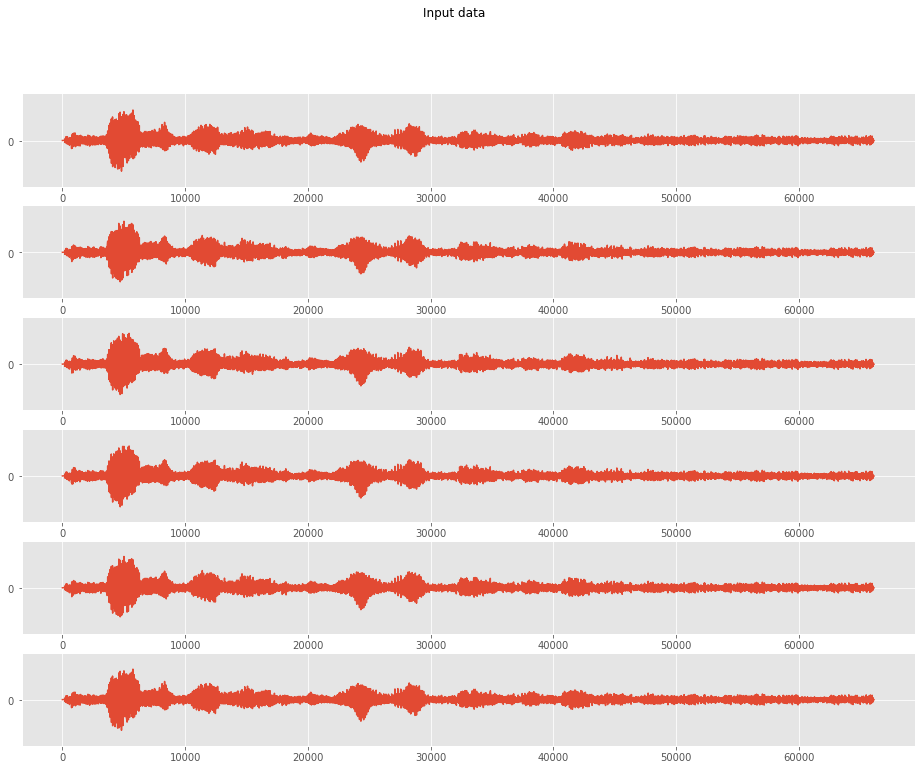

In [32]:
plt.figure(figsize=(16, 12))
for i in range(inputs.shape[0]):
    plt.subplot(inputs.shape[0], 1, i+1)
    plt.plot(inputs[i])
    plt.ylim([v_min, v_max])
    plt.yscale('symlog')
plt.suptitle("Input data")    
plt.plot()

In [35]:
label_voices = label_voice_signals[0,0,0,:].cpu().detach().numpy()
label_bg = label_bg_signals[0,0,:,:].cpu().detach().numpy()
print(label_voices.shape)

(6, 66150)


[]

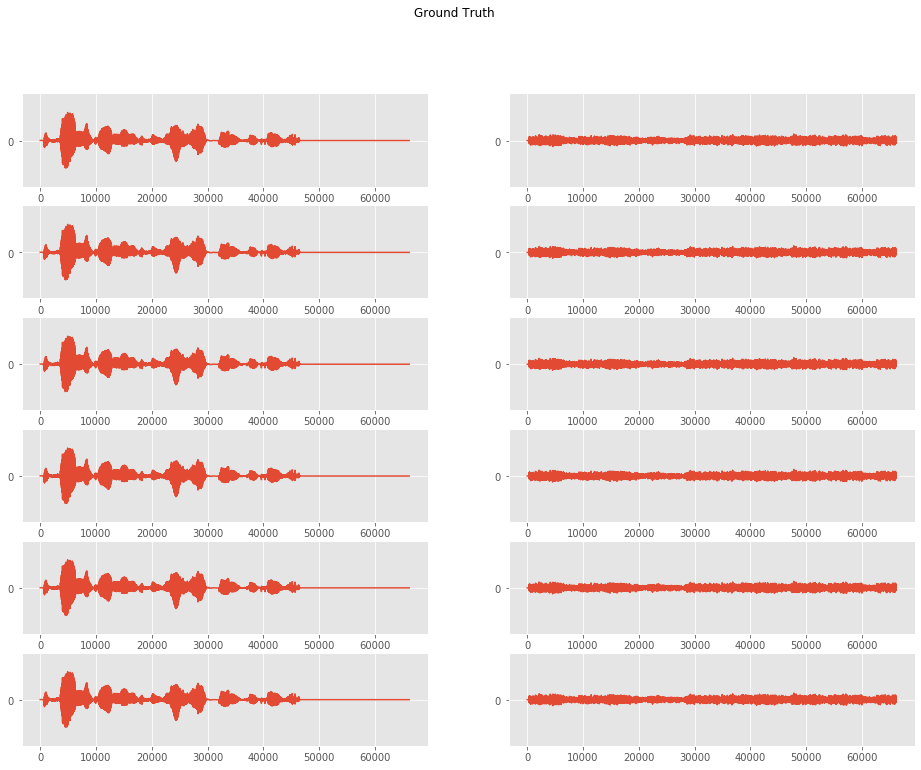

In [34]:
plt.figure(figsize=(16, 12))
for i in range(label_voices.shape[0]):
    plt.subplot(label_voices.shape[0], 2, 2*i+1)
    plt.plot(label_voices[i])
    plt.ylim([v_min, v_max])
    plt.yscale('symlog')
    plt.subplot(label_voices.shape[0], 2, 2*i+2)
    plt.plot(label_bg[i])
    plt.ylim([v_min, v_max])
    plt.yscale('symlog')
plt.suptitle("Ground Truth")    
plt.plot()

In [100]:
np.max(label_bg)

0.40377808

In [101]:
np.max(label_voices)

0.7375488

In [32]:
output_voice_signals = output_voices.cpu().detach().numpy()

[]

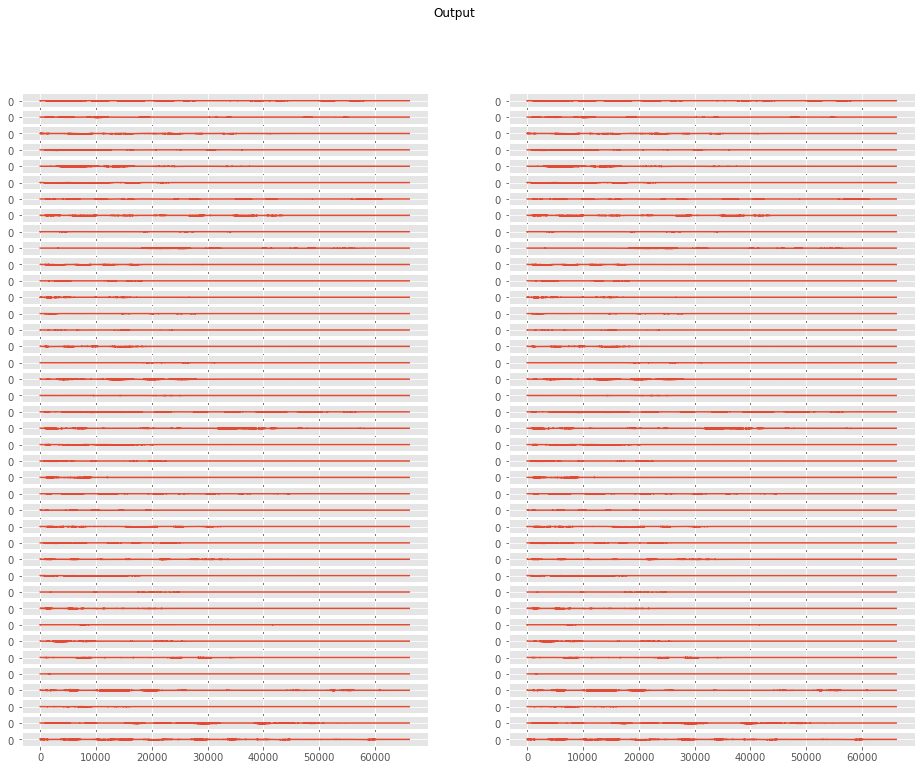

In [36]:
plt.figure(figsize=(16, 12))
for i in range(output_voice_signals.shape[0]):
    plt.subplot(output_voice_signals.shape[0], 2, 2*i+1)
    plt.plot(output_voice_signals[i])
    plt.ylim([v_min, v_max])
    plt.yscale('symlog')
    plt.subplot(output_voice_signals.shape[0], 2, 2*i+2)
    plt.plot(output_voice_signals[i])
    plt.ylim([v_min, v_max])
    plt.yscale('symlog')
plt.suptitle("Output")
plt.plot()

In [70]:
ipd.Audio(data=(inputs[0]), rate=22050)

In [41]:
ipd.Audio(data=(label_voices[10]), rate=22050, normalize=False)

NameError: name 'label_voices' is not defined

In [106]:
ipd.Audio(data=(label_bg[0]), rate=22050, normalize=False)

In [107]:
np.min(output_voice_signals[0])

-0.5581537

In [68]:
np.min(label_voices[0])

-0.52023315

In [40]:
ipd.Audio(data=(output_voice_signals[10]), rate=22050, normalize=True)

In [110]:
ipd.Audio(data=(output_bg_signals[0]), rate=22050, normalize=True)

In [55]:
from librosa.core import stft, istft
from librosa.display import specshow

In [56]:
y = output_voices[0].detach().cpu().numpy()

[]

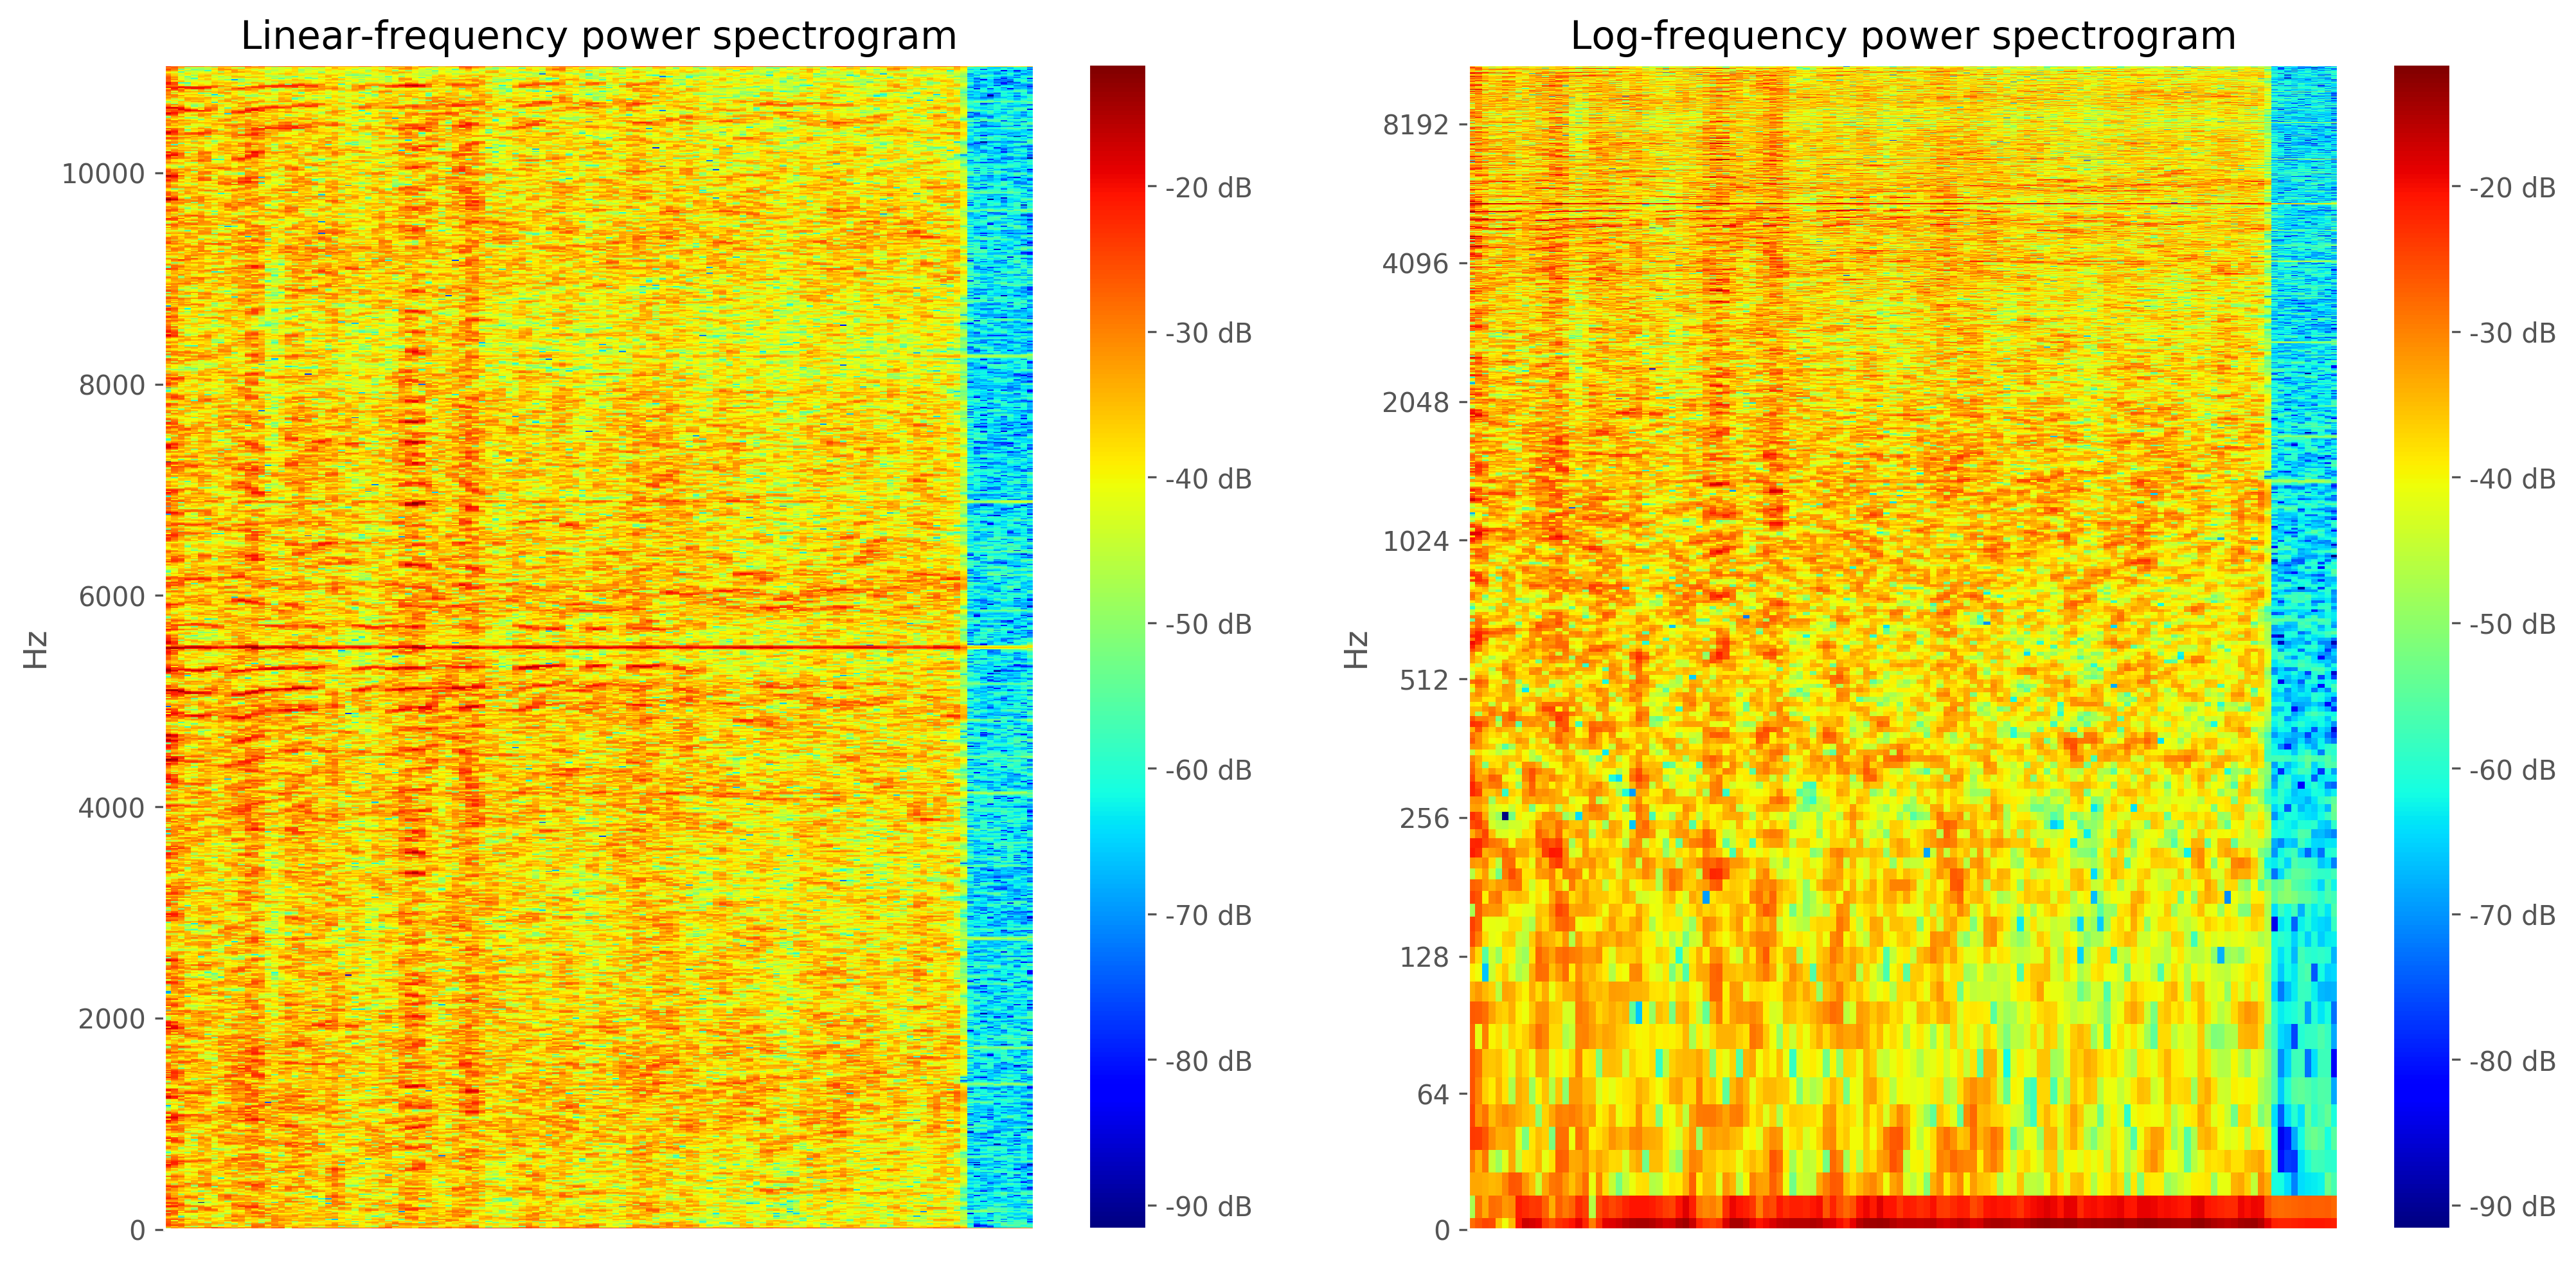

In [57]:
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=1.0)
plt.figure(figsize=(16, 8), dpi=300)
plt.subplot(1, 2, 1)
librosa.display.specshow(D, y_axis='linear', cmap=cm.jet)
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram')
plt.subplot(1, 2, 2)
librosa.display.specshow(D, y_axis='log', cmap=cm.jet)
plt.colorbar(format='%+2.0f dB')
plt.title('Log-frequency power spectrogram')
plt.plot()

In [68]:
# D = np.clip(D, -20, 0)

[]

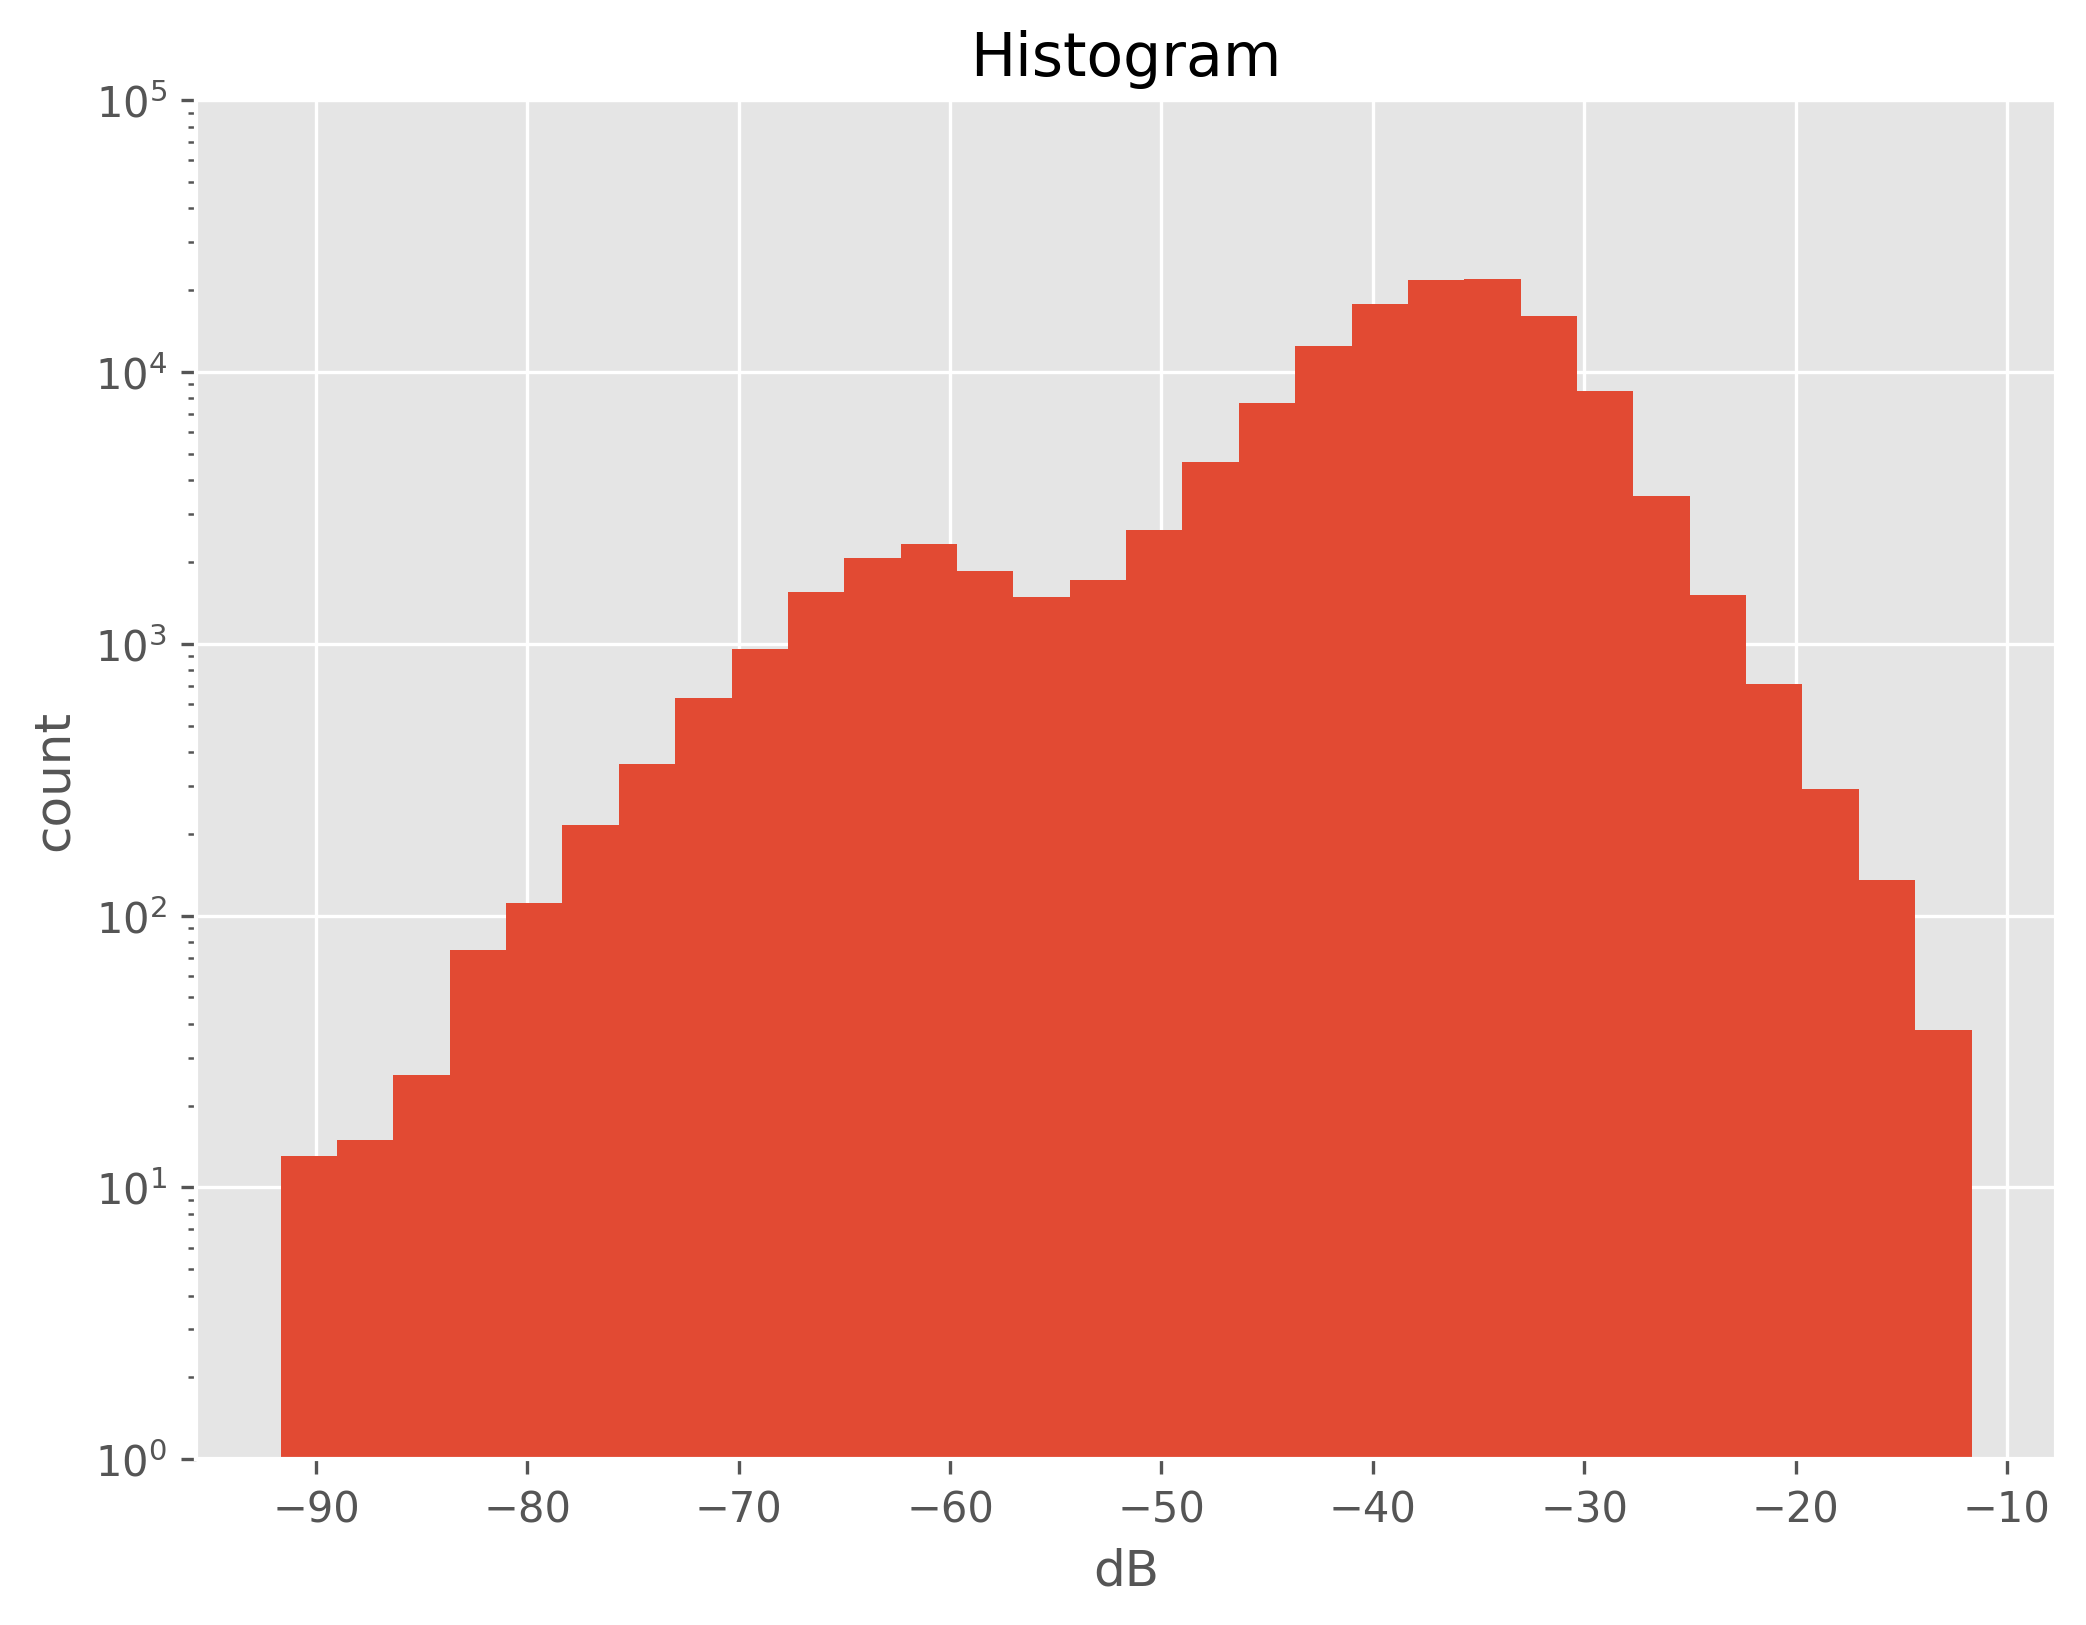

In [71]:
plt.figure(figsize=(8,6), dpi=300)
counts, bins = np.histogram(D, bins=30)
plt.hist(bins[:-1], bins, weights=counts)
plt.ylim([1, 1e5])
plt.yscale('log')
plt.ylabel('count')
plt.xlabel('dB')
plt.title('Histogram')
plt.plot()

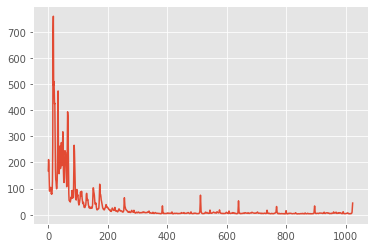

In [70]:
Y = stft(y)
plt.plot(np.sum(np.abs(Y), axis=1))

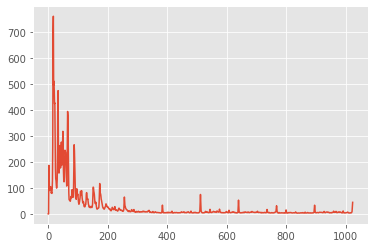

In [71]:
Y[:2, :] = 0
plt.plot(np.sum(np.abs(Y), axis=1))

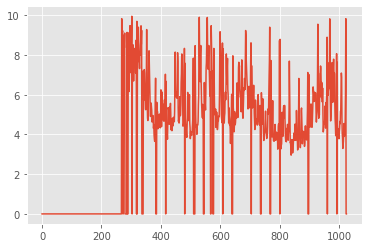

In [72]:
Y[np.where(np.sum(np.abs(Y), axis=1) >= 10), :] = 0
plt.plot(np.sum(np.abs(Y), axis=1))

In [73]:
# Y = librosa.util.normalize(Y)

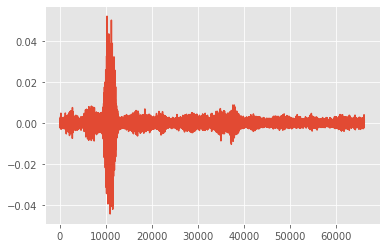

In [74]:
plt.plot(istft(Y))

Text(0.5, 1.0, 'Log-frequency power spectrogram')

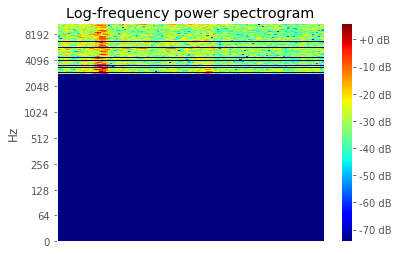

In [75]:
D = librosa.amplitude_to_db(np.abs(Y), ref=1.0)
librosa.display.specshow(D, y_axis='log', cmap=cm.jet)
plt.colorbar(format='%+2.0f dB')
plt.title('Log-frequency power spectrogram')

In [76]:
newy = istft(Y)

[]

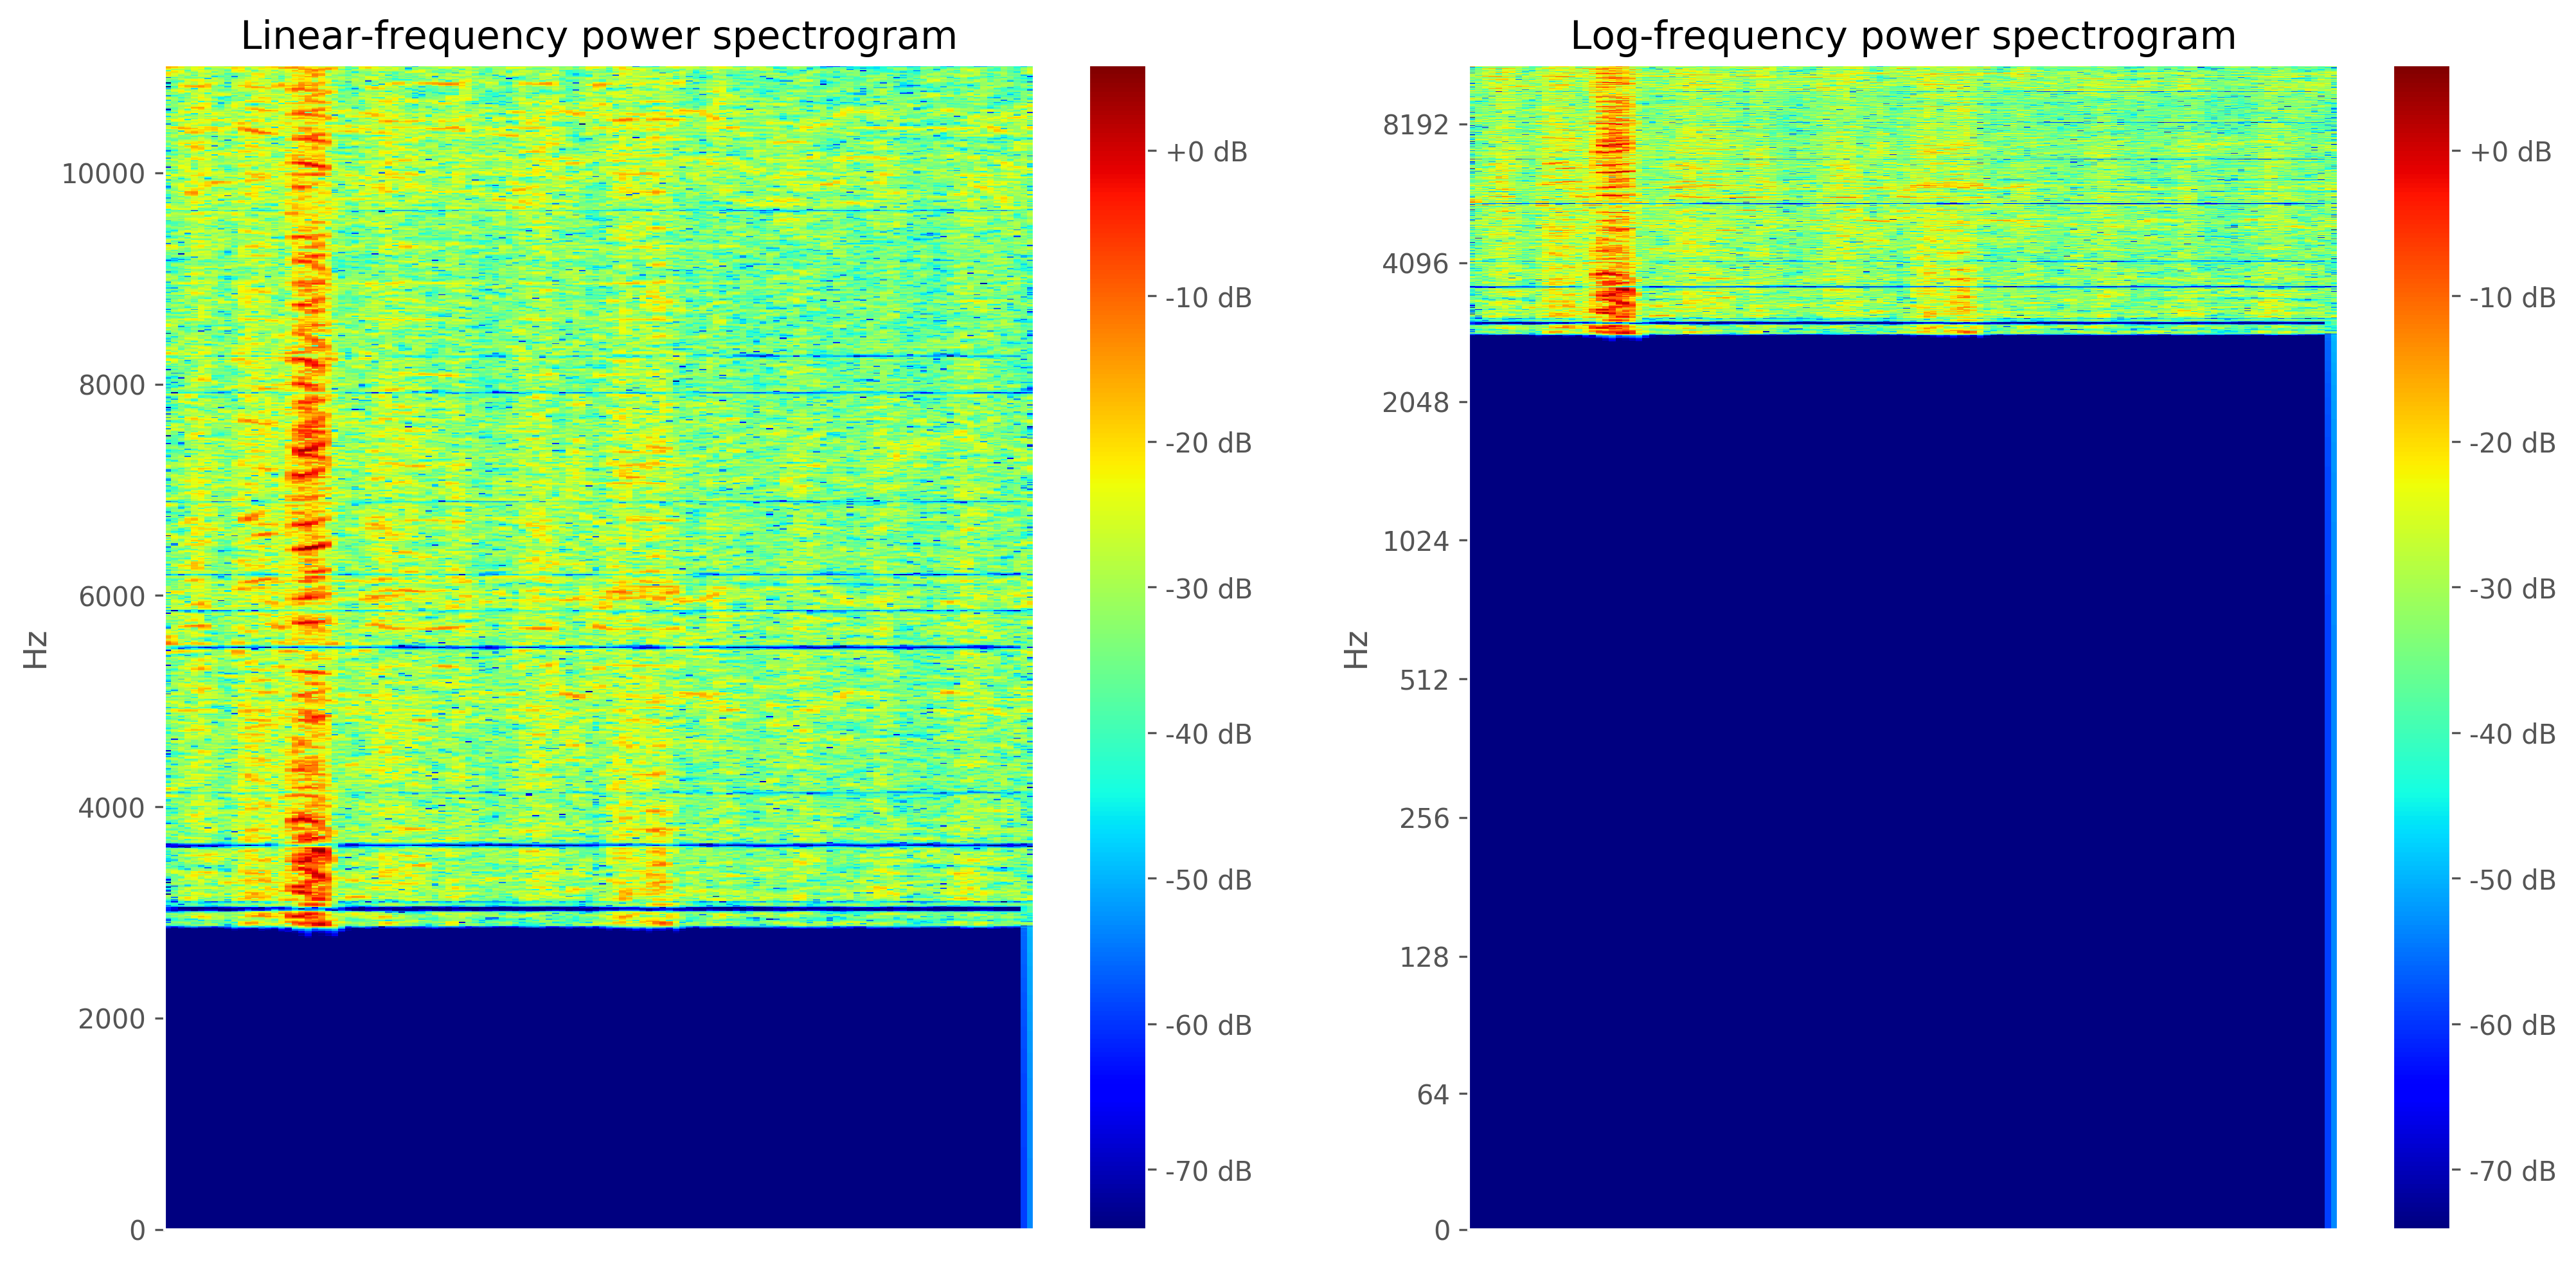

In [77]:
D = librosa.amplitude_to_db(np.abs(librosa.stft(newy)), ref=1.0)
plt.figure(figsize=(16, 8), dpi=300)
plt.subplot(1, 2, 1)
librosa.display.specshow(D, y_axis='linear', cmap=cm.jet)
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram')
plt.subplot(1, 2, 2)
librosa.display.specshow(D, y_axis='log', cmap=cm.jet)
plt.colorbar(format='%+2.0f dB')
plt.title('Log-frequency power spectrogram')
plt.plot()

[]

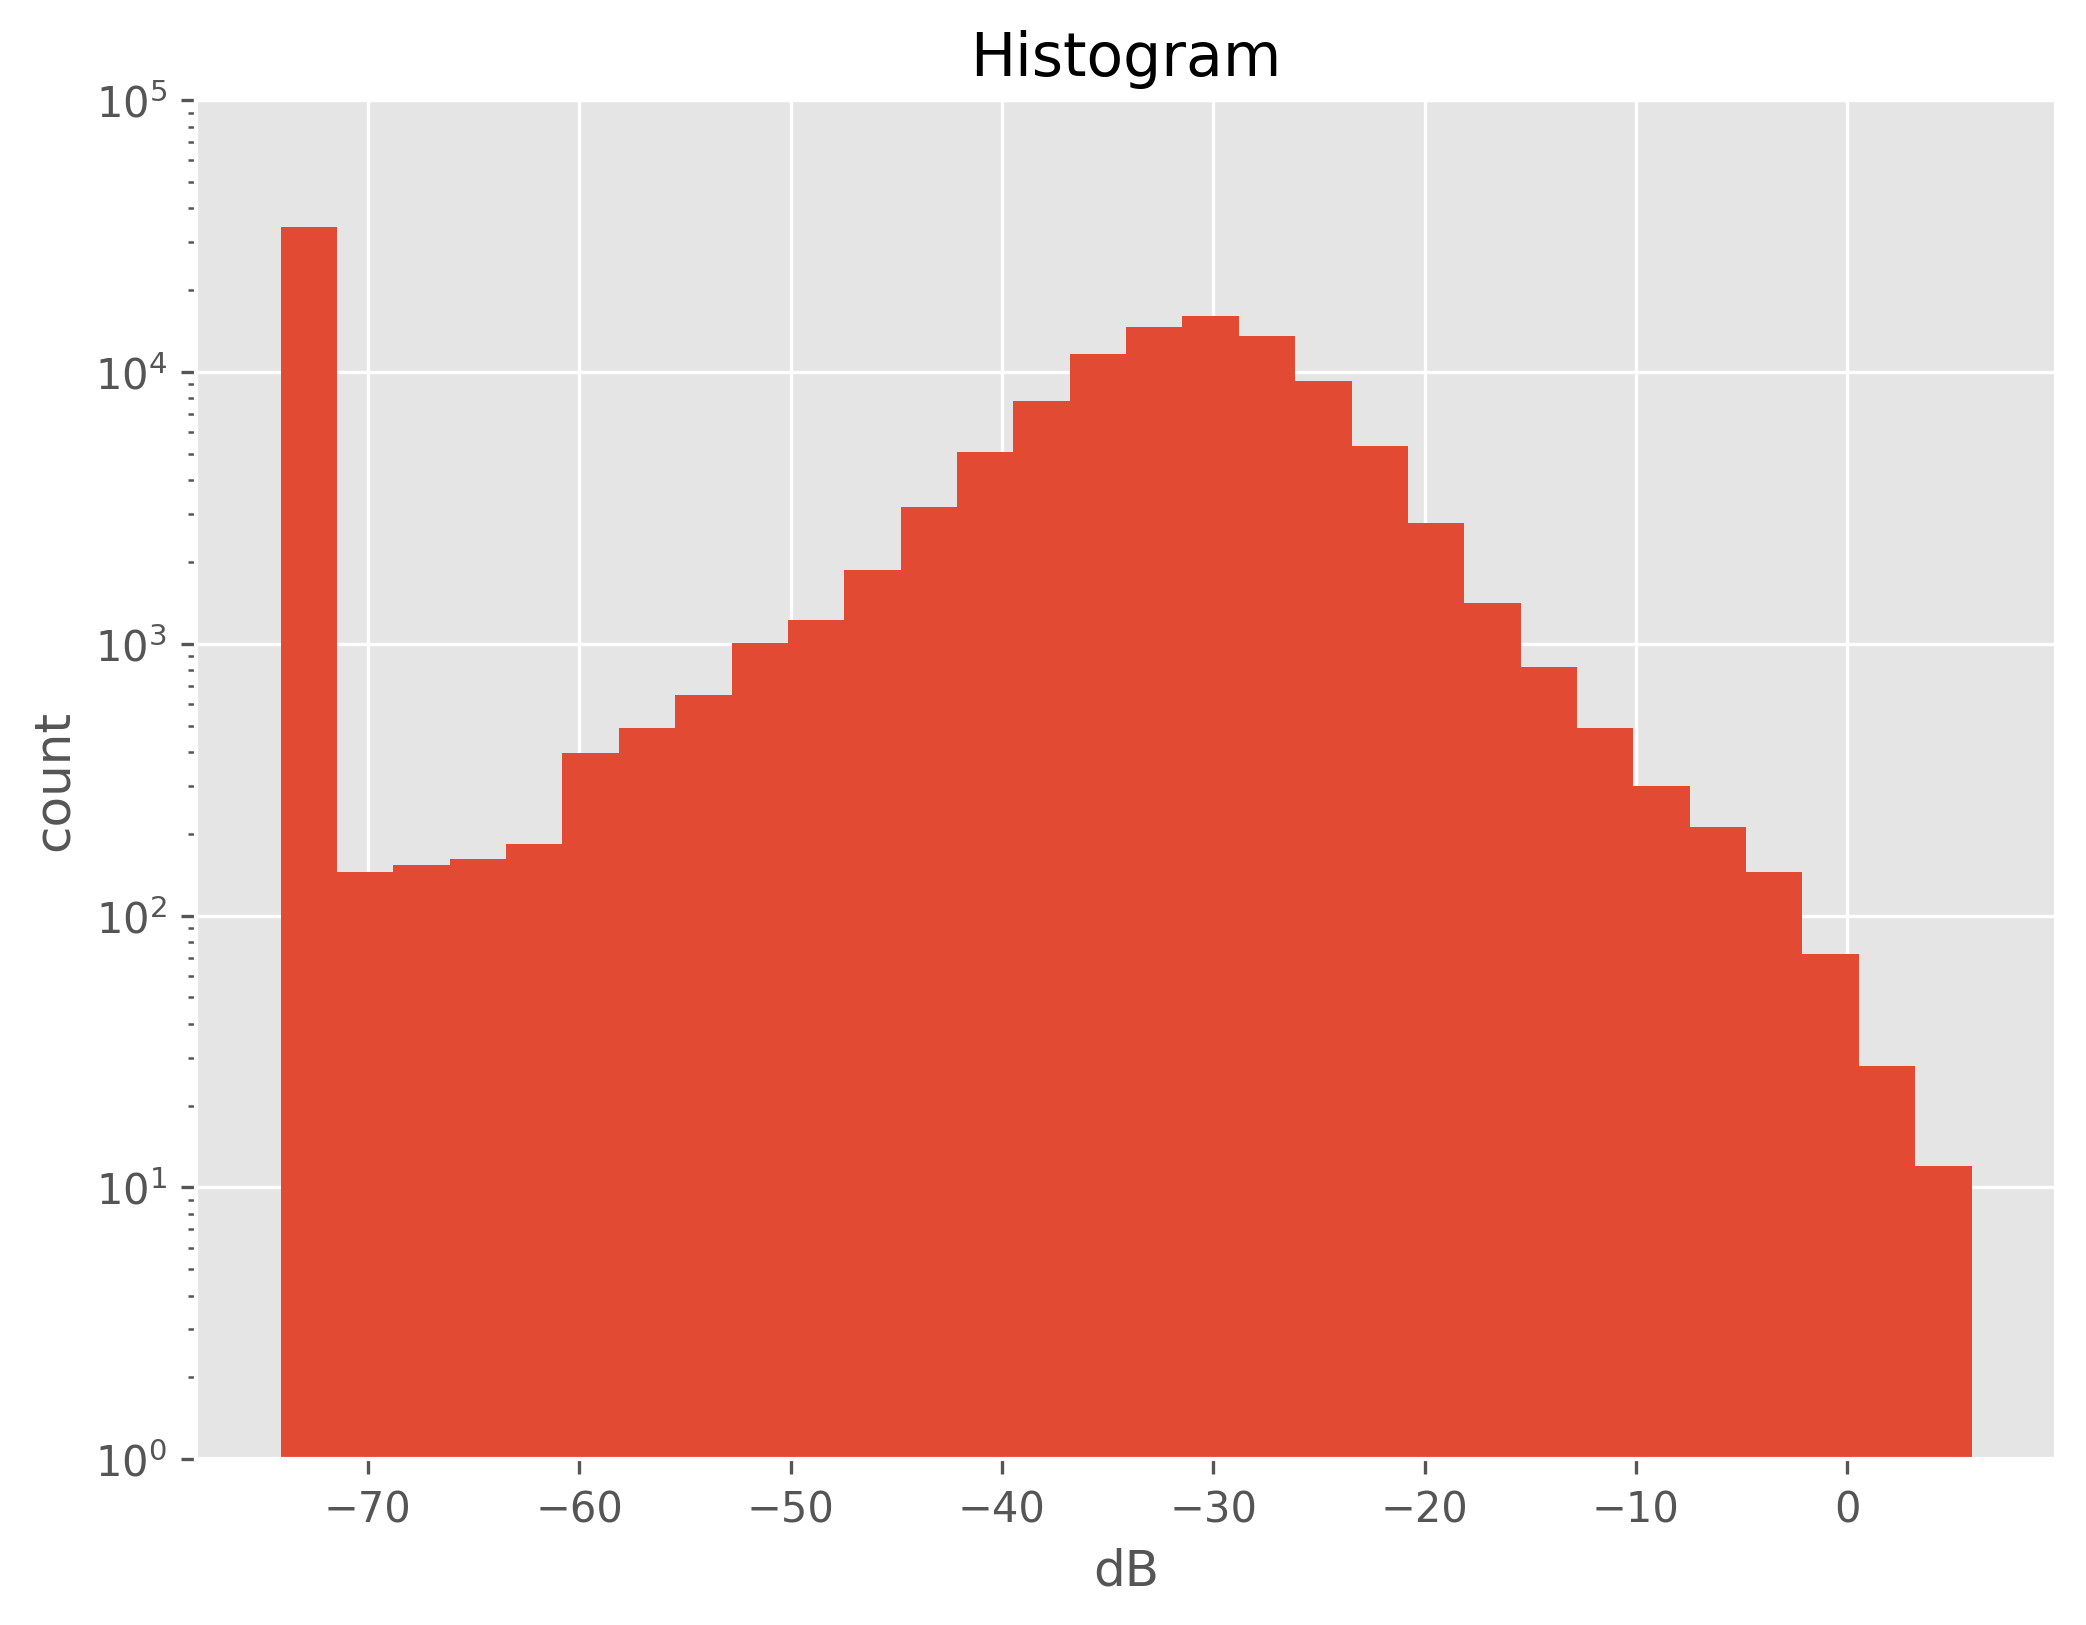

In [78]:
plt.figure(figsize=(8,6), dpi=300)
counts, bins = np.histogram(D, bins=30)
plt.hist(bins[:-1], bins, weights=counts)
plt.ylim([1, 1e5])
plt.yscale('log')
plt.ylabel('count')
plt.xlabel('dB')
plt.title('Histogram')
plt.plot()

[]

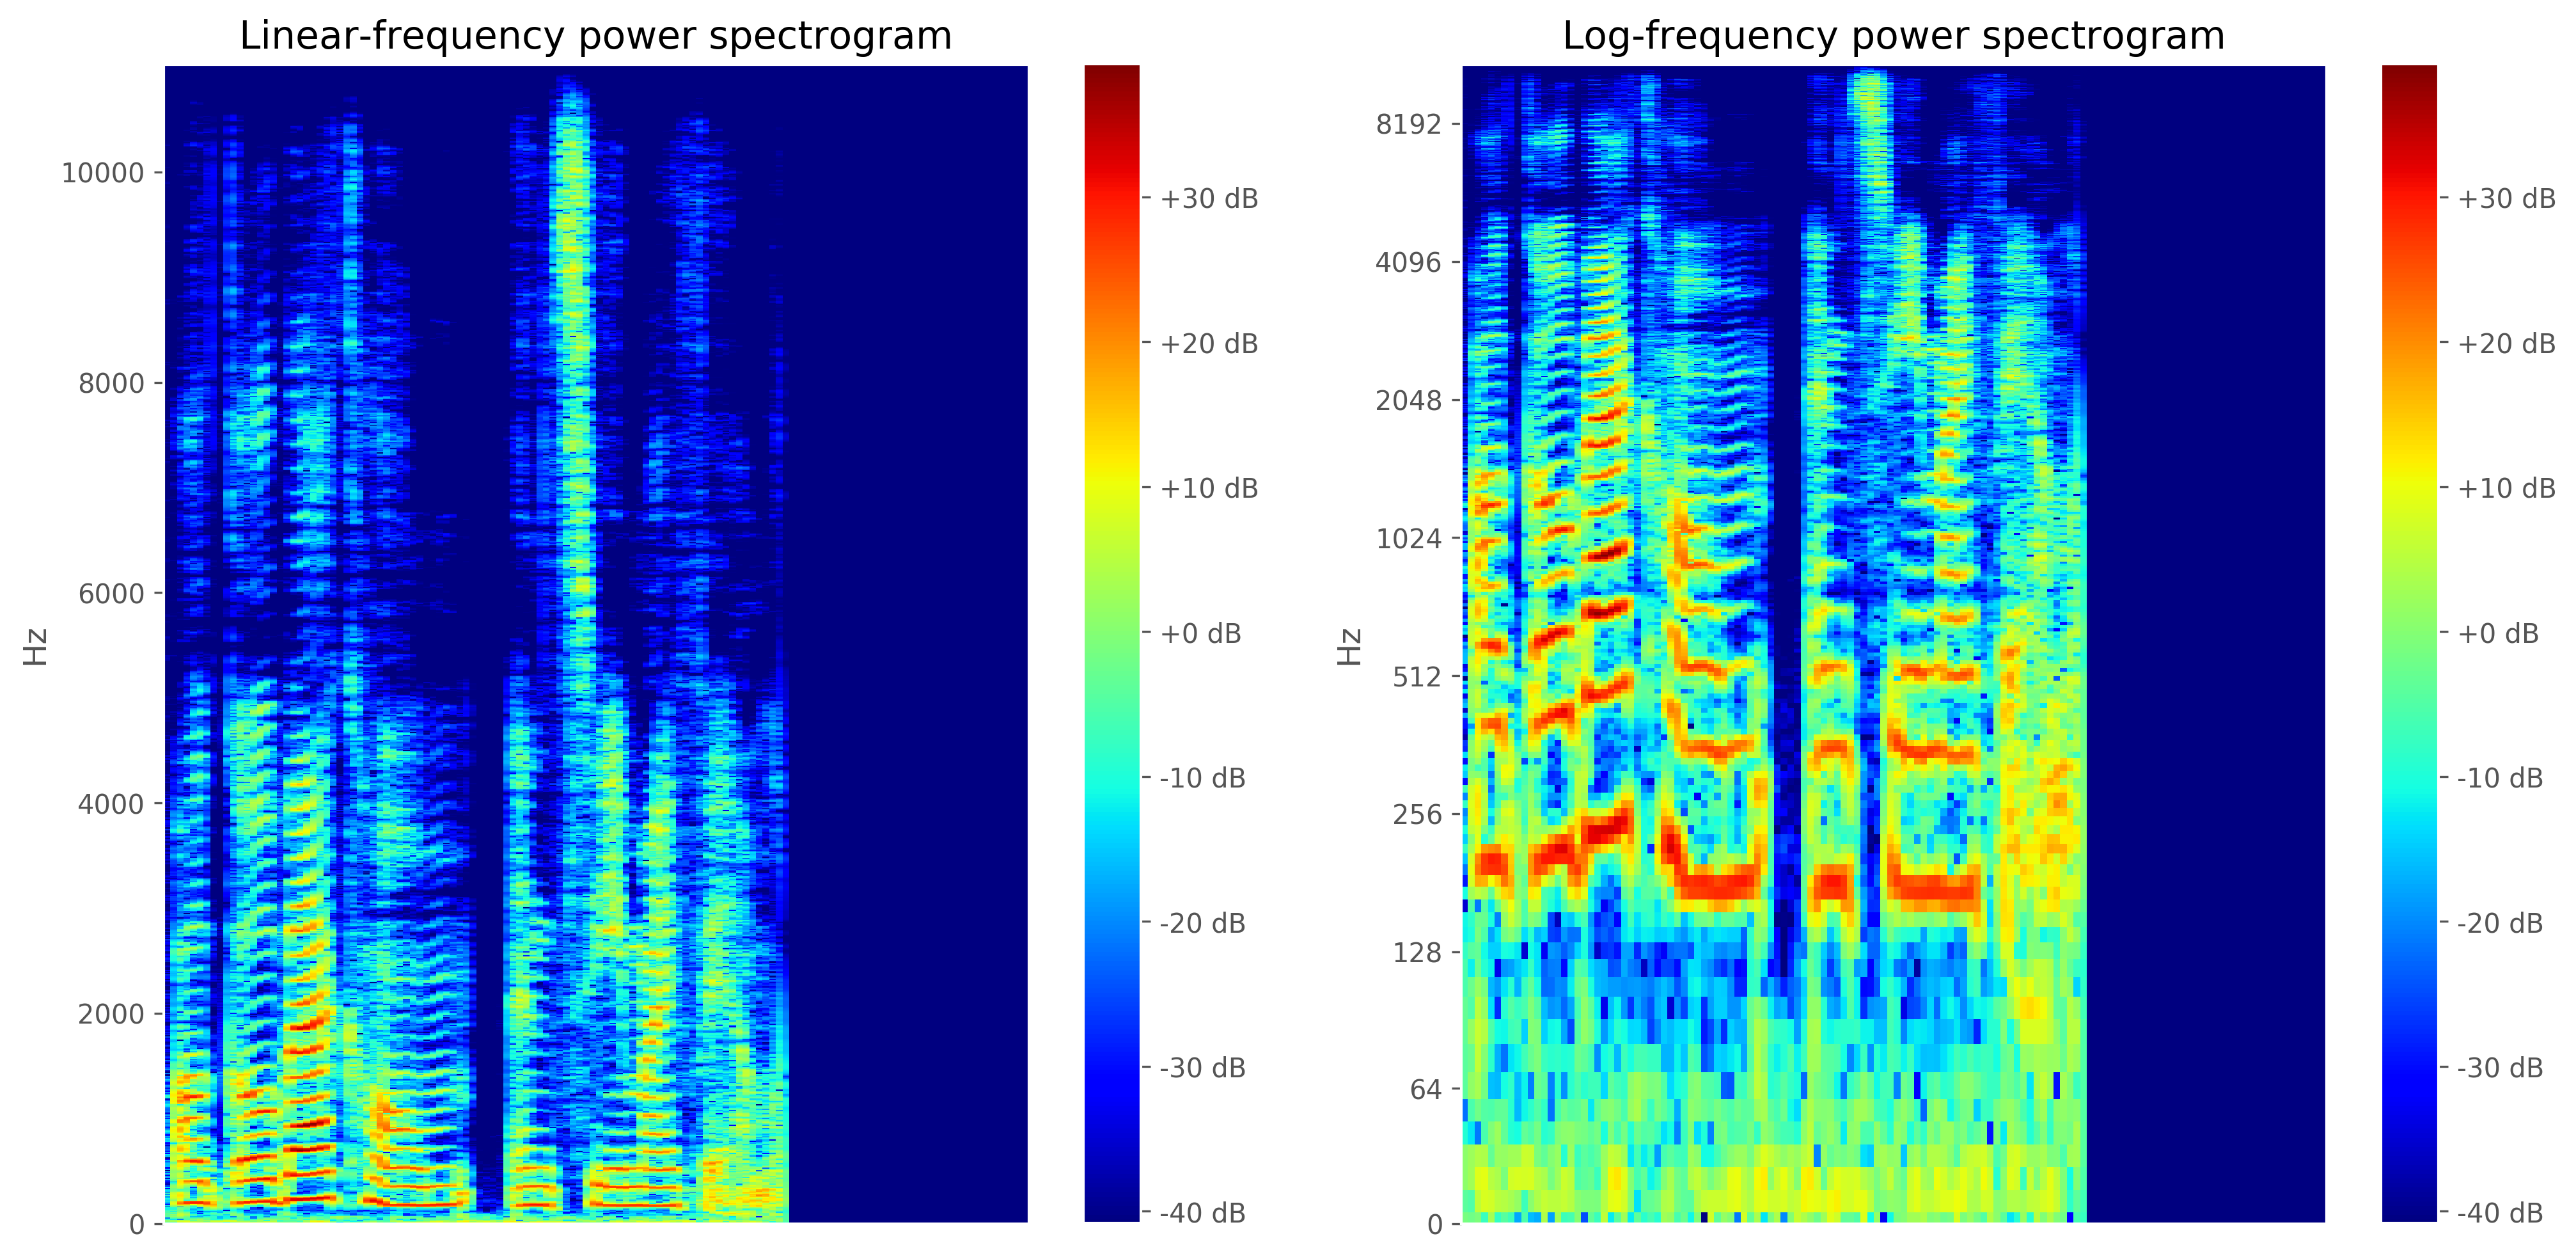

In [79]:
y_gt = label_voices[0]
D = librosa.amplitude_to_db(np.abs(librosa.stft(y_gt)), ref=1.0)
plt.figure(figsize=(16, 8), dpi=300)
plt.subplot(1, 2, 1)
librosa.display.specshow(D, y_axis='linear', cmap=cm.jet)
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram')
plt.subplot(1, 2, 2)
librosa.display.specshow(D, y_axis='log', cmap=cm.jet)
plt.colorbar(format='%+2.0f dB')
plt.title('Log-frequency power spectrogram')
plt.plot()

[]

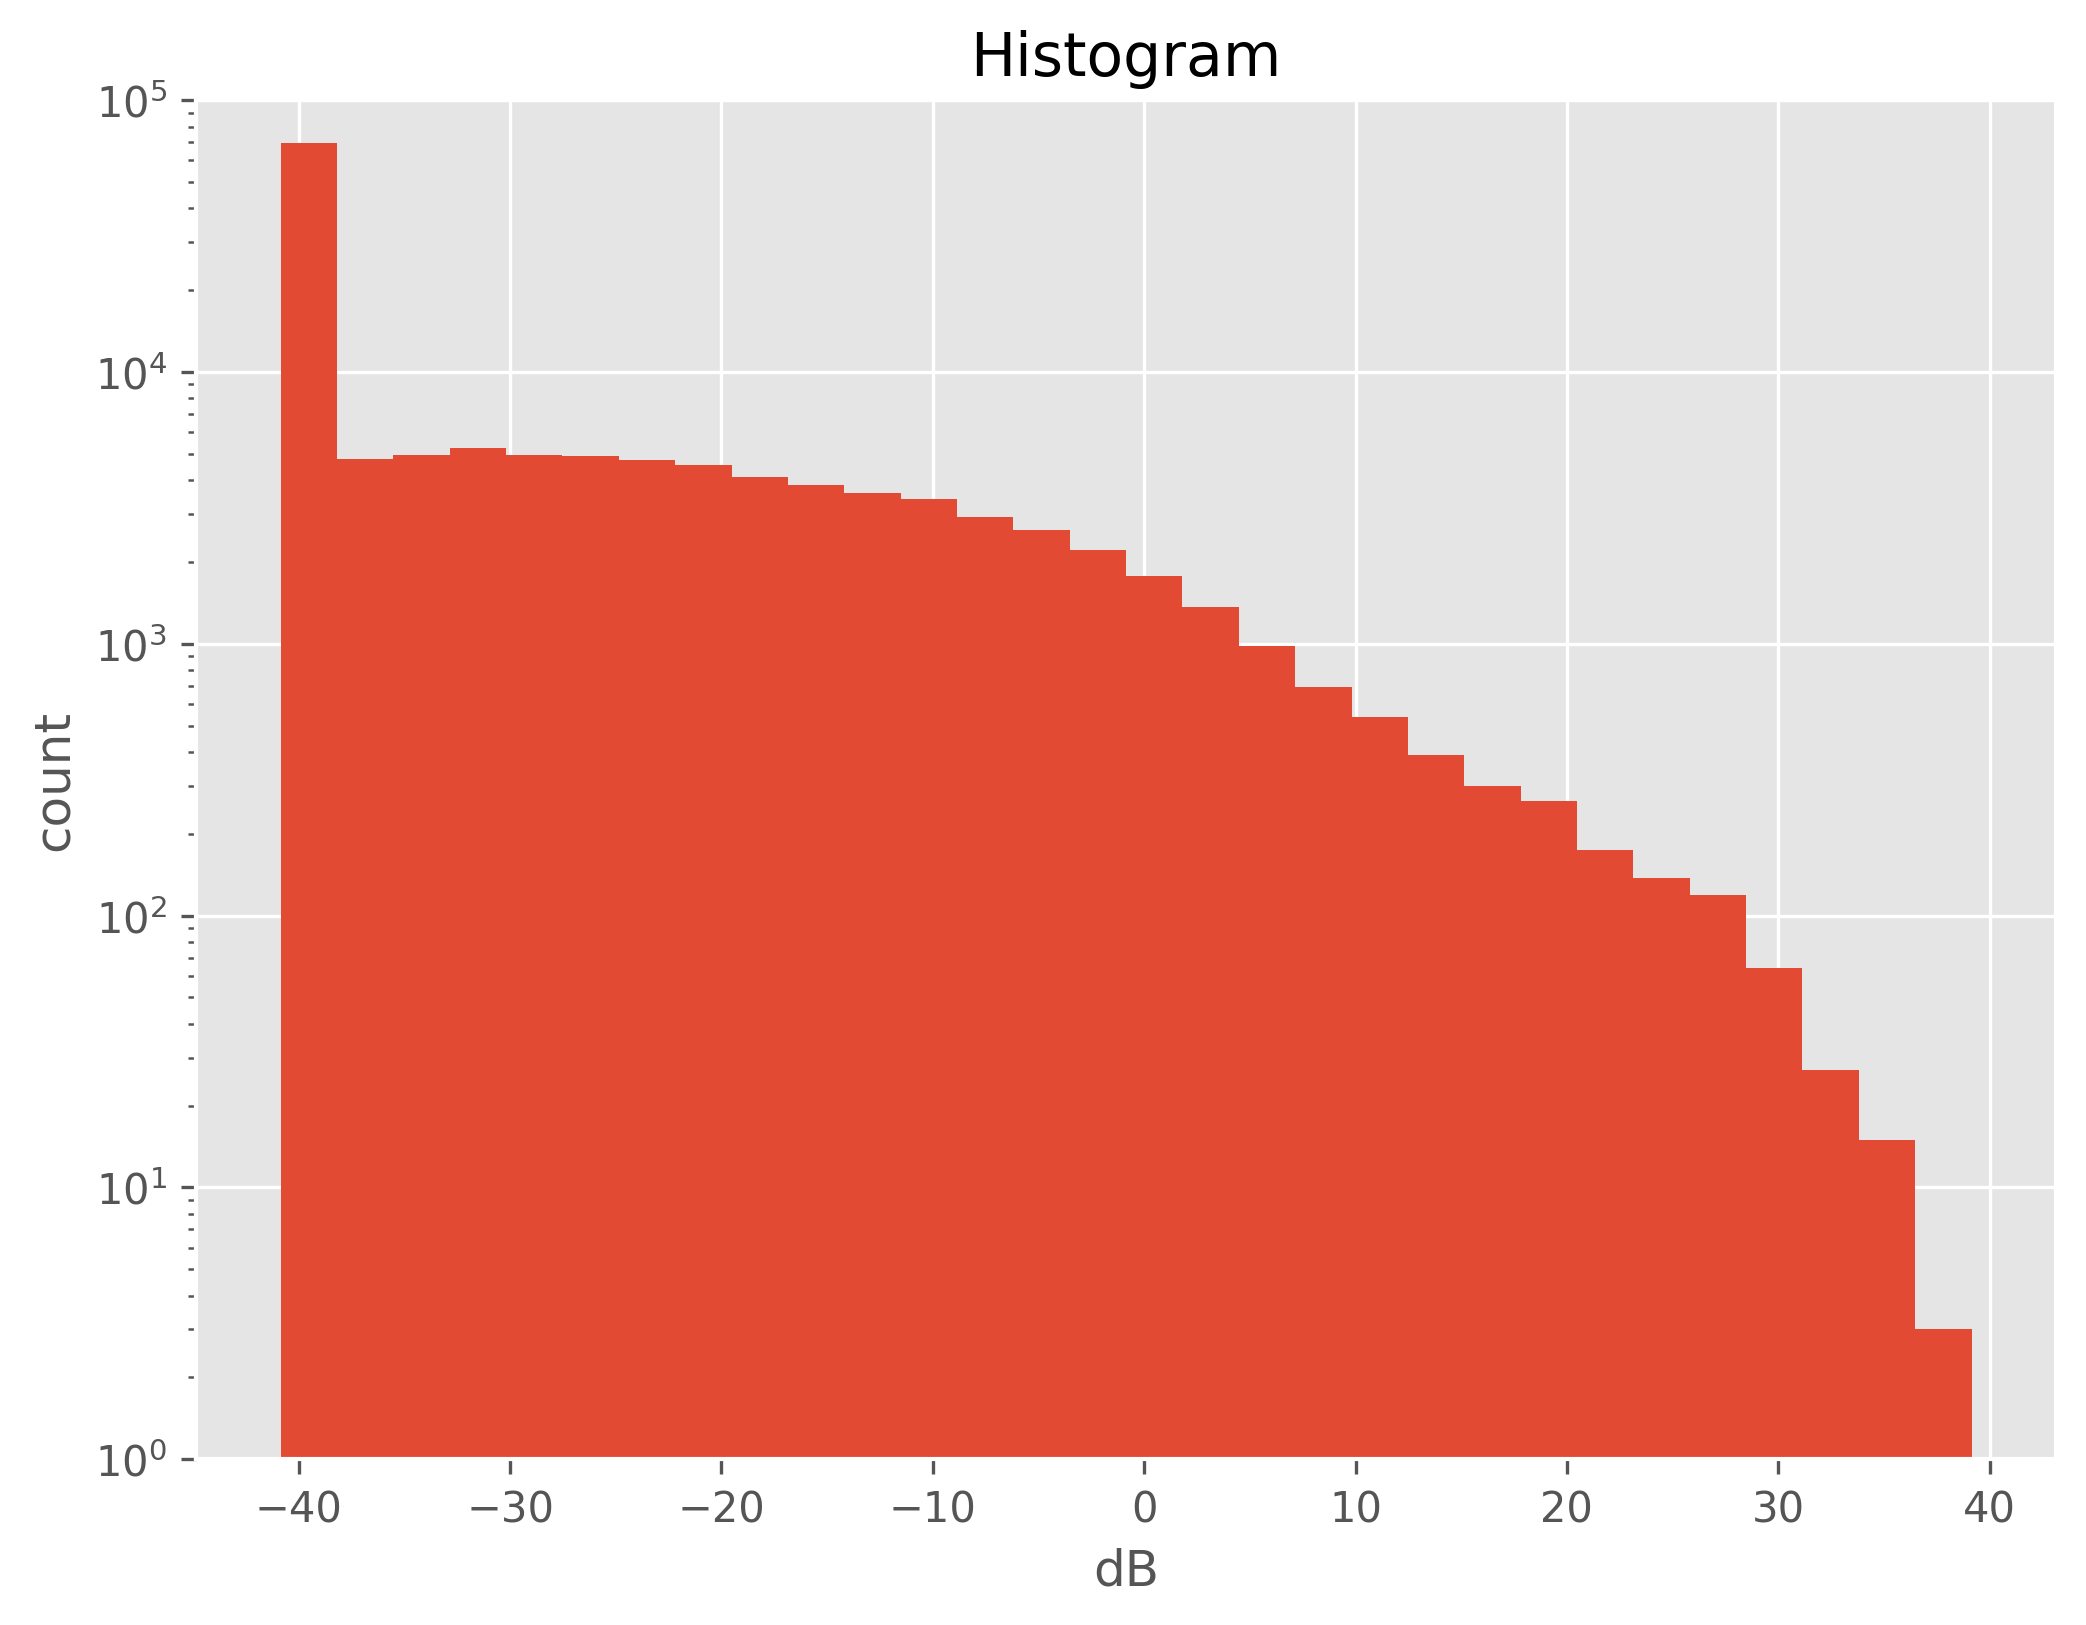

In [80]:
plt.figure(figsize=(8,6), dpi=300)
counts, bins = np.histogram(D, bins=30)
plt.hist(bins[:-1], bins, weights=counts)
plt.ylim([1, 1e5])
plt.yscale('log')
plt.ylabel('count')
plt.xlabel('dB')
plt.title('Histogram')
plt.plot()

In [84]:
x = data[0][1].cpu().numpy()

In [85]:
ipd.Audio(data=(newy), rate=22050)

In [83]:
ipd.Audio(data=(labels[3]), rate=22050)

NameError: name 'labels' is not defined

In [ ]:
ipd.Audio(data=(newy), rate=22050)

In [ ]:
top = np.sum(librosa.util.normalize(outputs[0]) ** 2) / outputs[0].shape[0]
bottom = np.sum(librosa.util.normalize(labels[0]) ** 2) / labels[0].shape[0]

In [ ]:
SDR = 10 * np.log10(top / bottom)

In [ ]:
print(SDR)

In [ ]:
binaural = False
if outputs.shape[0] == 2:
    binaural = True

In [ ]:
import os
base_dir = 'jan24'
os.makedirs(base_dir, exist_ok=True)

In [ ]:
if not binaural:
    for i in range(outputs.shape[0]):
        librosa.output.write_wav('{}/input_{}.wav'.format(base_dir, i), inputs[i], sr=22050)
        librosa.output.write_wav('{}/output_{}.wav'.format(base_dir, i), 100 * outputs[i], sr=22050)
        librosa.output.write_wav('{}/label_{}.wav'.format(base_dir, i), labels[i], sr=22050)
else:
    librosa.output.write_wav('{}/input.wav'.format(base_dir, i), np.asfortranarray(np.vstack(inputs)), sr=22050)
    librosa.output.write_wav('{}/output.wav'.format(base_dir, i), np.asfortranarray(np.vstack(outputs)), sr=22050)
    librosa.output.write_wav('{}/label.wav'.format(base_dir, i), np.asfortranarray(np.vstack(labels)), sr=22050)
        

233 => 1.121
150 => 1.835
100 => 1.036
50 => 0.648